In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

In [2]:
# Load data
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')  # 0=malignant, 1=benign

In [3]:
# Check data
print(f"Shape: {X.shape}")
print(f"Class distribution:\n{y.value_counts()}")

Shape: (569, 30)
Class distribution:
target
1    357
0    212
Name: count, dtype: int64


In [4]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#  Linear SVC Model
svc_linear = SVC(kernel='linear', C=1.0, random_state=42)
svc_linear.fit(X_train_scaled, y_train)

SVC(kernel='linear', random_state=42)

In [7]:
# Prediction
y_pred_linear = svc_linear.predict(X_test_scaled)

In [8]:
# RBF SVC Model
svc_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svc_rbf.fit(X_train_scaled, y_train)

SVC(random_state=42)

In [9]:
# Prediction
y_pred_rbf = svc_rbf.predict(X_test_scaled)

In [10]:
# Evaluation
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Performance:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))

evaluate_model(y_test, y_pred_linear, "Linear SVC")
evaluate_model(y_test, y_pred_rbf, "RBF SVC")


Linear SVC Performance:
Accuracy: 0.9736842105263158
Precision: 0.9859154929577465
Recall: 0.9722222222222222
F1 Score: 0.9790209790209791

RBF SVC Performance:
Accuracy: 0.9824561403508771
Precision: 0.9861111111111112
Recall: 0.9861111111111112
F1 Score: 0.9861111111111112


In [12]:
# Hyperparameter Tuning (GridSearchCV)
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1],          # Regularization strength
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'degree': [2, 3]                  # Only for 'poly' kernel
}

svc_grid = GridSearchCV(
    SVC(random_state=42), 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

svc_grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .........C=0.1, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .........C=0.1, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .........C=0.1, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .........C=0.1, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ............C=0.1, degree=2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ............C=0.1, degree=2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ............C=0.1, degree=2, gamma=auto

GridSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1], 'degree': [2, 3],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=2)

In [13]:
# Best parameters
print("Best Parameters:", svc_grid.best_params_)

Best Parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}


In [14]:
best_svc = svc_grid.best_estimator_
y_pred_tuned = best_svc.predict(X_test_scaled)

evaluate_model(y_test, y_pred_tuned, "Tuned SVC")


Tuned SVC Performance:
Accuracy: 0.9824561403508771
Precision: 0.9861111111111112
Recall: 0.9861111111111112
F1 Score: 0.9861111111111112


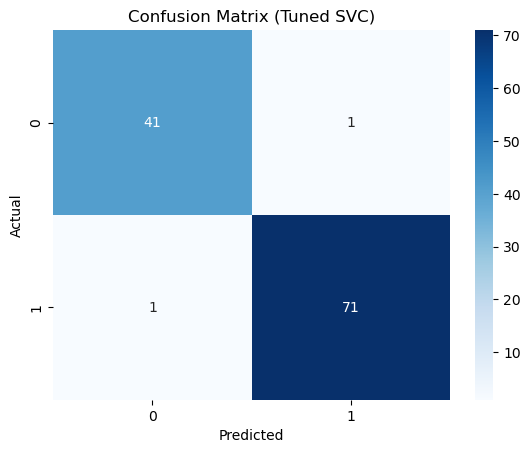

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Tuned SVC)")
plt.show()

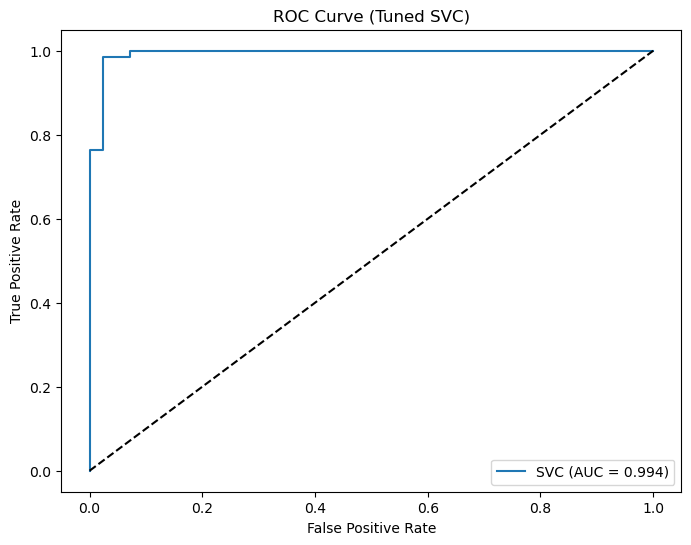

In [16]:
# ROC Curve
y_proba = best_svc.decision_function(X_test_scaled)  # Not predict_proba for SVC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"SVC (AUC = {roc_auc_score(y_test, y_proba):.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Tuned SVC)")
plt.legend()
plt.show()

In [18]:
# Feature Importance
result = permutation_importance(
    best_svc, X_test_scaled, y_test, n_repeats=10, random_state=42
)
importance_df = pd.DataFrame({
    'Feature': data.feature_names,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

print("Top 5 Important Features:")
print(importance_df.head())

Top 5 Important Features:
                Feature  Importance
10         radius error    0.028947
7   mean concave points    0.026316
24     worst smoothness    0.026316
21        worst texture    0.025439
6        mean concavity    0.024561


In [ ]:
# Select Top Features
top_features = ['radius error', 'mean concave points']
X_train_2d = X_train_scaled[:, [data.feature_names.tolist().index(f) for f in top_features]]
X_test_2d = X_test_scaled[:, [data.feature_names.tolist().index(f) for f in top_features]]

In [ ]:
# Train SVC on 2D Subset
svc_2d = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
svc_2d.fit(X_train_2d, y_train)

SVC(C=10, random_state=42)

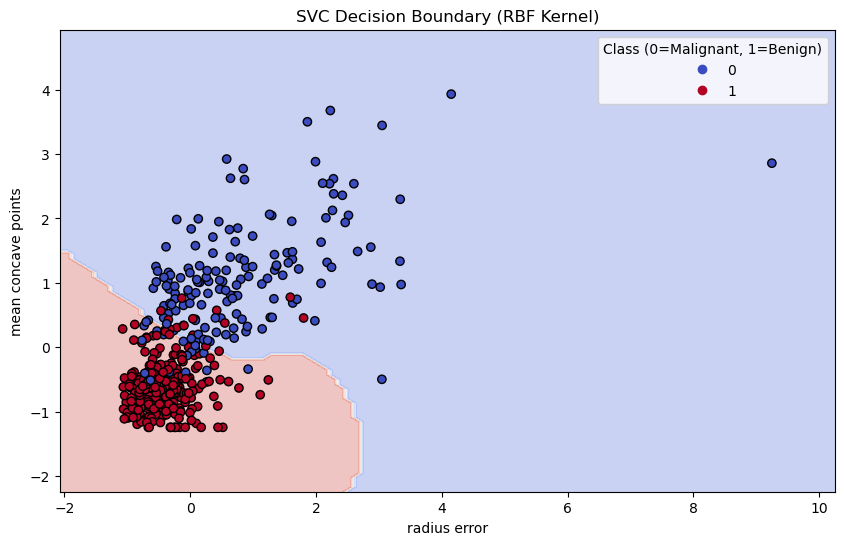

In [ ]:
# Plot Decision Boundary
def plot_decision_boundary(model, X, y, feature_names):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), 
                         np.linspace(y_min, y_max, 100))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k')
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title("SVC Decision Boundary (RBF Kernel)")
    plt.legend(*scatter.legend_elements(), title="Class (0=Malignant, 1=Benign)")
    plt.show()

# RBF Decision Boundary
plot_decision_boundary(svc_2d, X_train_2d, y_train, top_features)

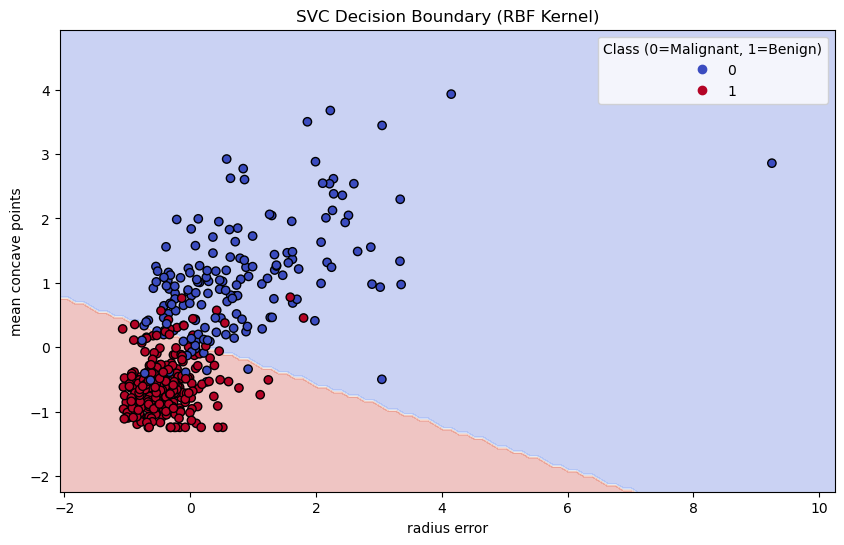

In [ ]:
# Linear Decision Boundary
svc_linear_2d = SVC(kernel='linear', C=10, random_state=42)
svc_linear_2d.fit(X_train_2d, y_train)
plot_decision_boundary(svc_linear_2d, X_train_2d, y_train, top_features)